# DistilBert

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions_5 import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics,
    get_error_analysis
)

### Setup

In [3]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
DATA_PATH = "../data/data_small.csv"
# DATA_PATH = "../data/data_tiny.csv" # uncomment this when checking that everything is just running properly. 
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
OUTPUT_DIR = "../models/distilbert_finetuned_1/trainer_output"
SAVE_PATH = "../models/distilbert_finetuned_1/pytorch_model"

### Get data

In [5]:
train_dataset, test_dataset, encoded_train_dataset, encoded_test_dataset, le = get_encode_tokenize_data(DATA_PATH, MODEL_PATH)

INFO:basic_functions_5:Loading data...
INFO:basic_functions_5:Train test split, test-size 0.3
INFO:root:encode the label column
INFO:root:tokenize
INFO:basic_functions_5:create tokenizer & load model
INFO:basic_functions_5:create tokenizer & load model
INFO:root:create TextDatasets (train & test)


In [6]:
y_train = encoded_train_dataset['logical_fallacies']

### Model Initialization

In [7]:
num_classes = len(np.unique(y_train))
num_classes

6

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    num_labels=num_classes,
    problem_type="single_label_classification"
)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
params = {
      "learning_rate": 3e-5,
      "weight_decay": 0.01,
      "num_train_epochs": 4,
      "evaluation_strategy": "epoch",
      "class_weight":True,
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "test")
mlflow.log_params(params)

Active run_id: a03d7fc3491745cd97e173b31176f921


In [10]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=True, 
    epochs=4, 
    learning_rate=3e-5, 
    weight_decay = 0.01, 
    train_batch_size=4, 
    eval_batch_size=8 )

INFO:root:defining training arguments
INFO:root:get weighted loss trainer


### Execute Training

In [11]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [12]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [13]:
logger.info('training is running')
trainer.train()

INFO:root:training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,1.286800,1.141336,0.595000
2,0.776400,1.026461,0.626667
3,0.376600,1.179246,0.638333
4,0.177900,1.277198,0.648333


Could not locate the best model at ../models/distilbert_finetuned_1/trainer_output/checkpoint-700/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=1400, training_loss=0.7227466675213405, metrics={'train_runtime': 1649.6151, 'train_samples_per_second': 3.395, 'train_steps_per_second': 0.849, 'total_flos': 741870349516800.0, 'train_loss': 0.7227466675213405, 'epoch': 4.0})

### Evaluation


In [14]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

INFO:root:predict on test_dataset


INFO:basic_functions_5:get evaluation metrics
INFO:basic_functions_5:classification_report
INFO:basic_functions_5:confusion_matrix
INFO:basic_functions_5:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.66      0.64      0.65       101
  appeal_to_authority       0.65      0.75      0.70        87
    appeal_to_emotion       0.69      0.64      0.67       101
        false_dilemma       0.83      0.77      0.80       100
faulty_generalization       0.51      0.52      0.51       102
                 none       0.58      0.59      0.58       109

             accuracy                           0.65       600
            macro avg       0.65      0.65      0.65       600
         weighted avg       0.65      0.65      0.65       600

[[65  6 15  3  9  3]
 [ 4 65  4  1  7  6]
 [11  8 65  3  9  5]
 [ 4  4  2 77  2 11]
 [ 7  9  5  6 53 22]
 [ 7  8  3  3 24 64]]


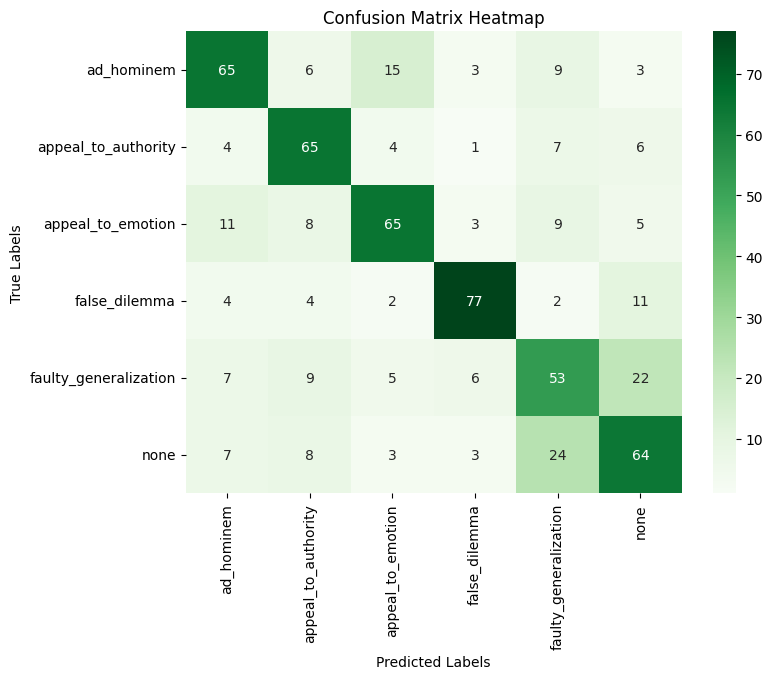

INFO:basic_functions_5:brier score


Multiclass Brier score: 0.5621220535409407


In [15]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


INFO:root:predict on train_dataset


INFO:basic_functions_5:get evaluation metrics
INFO:basic_functions_5:classification_report
INFO:basic_functions_5:confusion_matrix
INFO:basic_functions_5:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.97      0.99      0.98       234
  appeal_to_authority       0.98      0.97      0.98       204
    appeal_to_emotion       0.98      0.97      0.98       235
        false_dilemma       0.98      0.97      0.97       233
faulty_generalization       0.96      0.98      0.97       238
                 none       0.96      0.96      0.96       256

             accuracy                           0.97      1400
            macro avg       0.97      0.97      0.97      1400
         weighted avg       0.97      0.97      0.97      1400

[[232   0   1   0   1   0]
 [  1 197   1   0   2   3]
 [  2   2 228   0   0   3]
 [  1   0   0 225   2   5]
 [  1   1   1   1 234   0]
 [  2   0   1   3   4 246]]


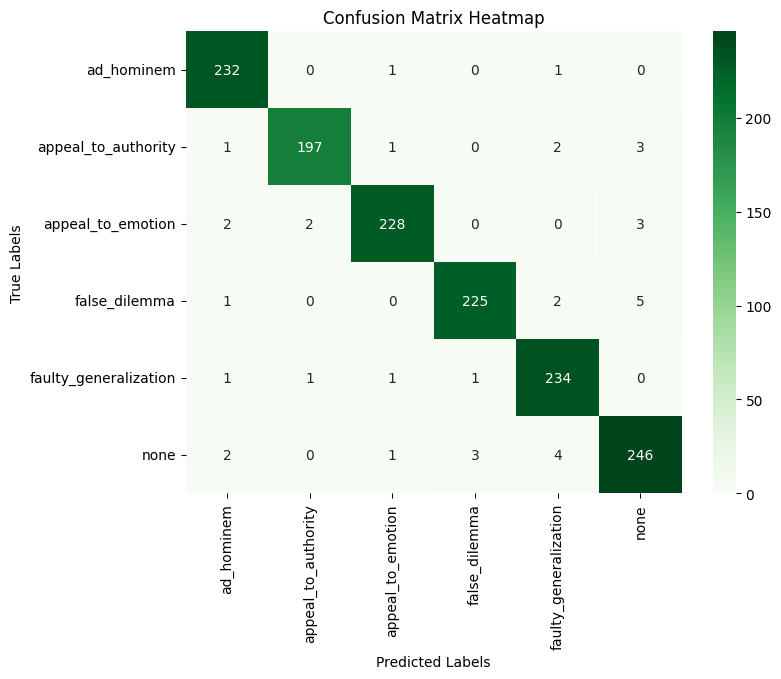

INFO:basic_functions_5:brier score


Multiclass Brier score: 0.043090878581253766


In [16]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [17]:
mlflow.end_run()

🏃 View run test at: http://127.0.0.1:5001/#/experiments/118053630762497624/runs/a03d7fc3491745cd97e173b31176f921
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/118053630762497624


### Save model

In [18]:
# save with pytorch
mlflow.pytorch.save_model(model, path=SAVE_PATH)

python(23034) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Error Analysis

In [19]:
def get_label(n):
    if n == 0:
        return "ad_hominem"
    if n == 1:
        return "appeal_to_authority"
    if n == 2:
        return "appeal_to_emotion"
    if n == 3:
        return "false_dilemma"
    if n == 4:
        return "faulty_generalization"
    if n == 5:
        return "none"
    else:
        return 'error'
    

In [20]:
encoded_test_dataset.head()

,dataset,text,logical_fallacies
75,2,You should marry me I know we re not compatibl...,appeal_to_emotion
305,9,My friend Phyllis Hunter is here She had one o...,appeal_to_authority
677,2,Either we raise taxes or we ll have no public ...,false_dilemma
1655,8,I dont want people to die That is so sad and m...,appeal_to_emotion
376,2,Of course she s saying that it s popular to su...,ad_hominem


In [21]:
import pandas as pd

def _get_error_analysis(output, encoded_df):
    y_pred = np.argmax(output.predictions, axis=1)

    y_true = output.label_ids

    encoded_df = encoded_df.reset_index()

    text = []
    dataset  = []
    true_label = []
    pred_label = []

    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if true != pred:
            text.append(encoded_df['text'][i])
            dataset.append(encoded_df['dataset'][i])
            true_label.append(true)
            pred_label.append(pred)
            print(f"Example {i}:")
            print(f"Text: {encoded_df['text'][i]}")
            print(f"True Label: {true}, Predicted Label: {pred}")

    return pd.DataFrame({'text': text, 'dataset': dataset, 'true_label': true_label, 'pred_label': pred_label})


In [22]:


df_error_test = _get_error_analysis(test_output, encoded_test_dataset)

Example 0:
Text: You should marry me I know we re not compatible but I only have a year to live and you re my last chance
True Label: 2, Predicted Label: 0
Example 9:
Text: And in the special session in which Senator Kennedy was calling the signals along with Senator Johnson they turned it down and he himself voted against giving us the powers despite the fact that the bill had already been considered before that it already had hearings on and the Congress already knew what it had before it
True Label: 0, Predicted Label: 1
Example 15:
Text: It is an article of faith for the globalist elite and their useful idiots in the media in politics in business and the entertainment that the world is on course for climate disaster which only radical and costly international action can prevent
True Label: 0, Predicted Label: 5
Example 19:
Text: Maybe the government of Cameroon is doing the right thing by restricting access to social media Otherwise hate speech and online violence would be rampant 

In [23]:
df_error_test['text_char_length'] = df_error_test['text'].map(lambda x : len(x))
df_error_test['text_word_length'] = df_error_test['text'].str.split().str.len()

In [24]:
df_error_test.head()

,text,dataset,true_label,pred_label,text_char_length,text_word_length
0,You should marry me I know we re not compatibl...,2,2,0,104,24
1,And in the special session in which Senator Ke...,9,0,1,322,57
2,It is an article of faith for the globalist el...,1,0,5,244,42
3,Maybe the government of Cameroon is doing the ...,3,5,3,572,97
4,Conversation of the Deaths covid19 coronavirus...,4,2,0,218,25


In [25]:
df_error_test.groupby(['dataset', 'true_label']).max()

text   
dataset true_label                                                      
1       0           Yet their dismal track record seems to lead to...  \
        2           You don t worry much about dengue or malaria i...   
        3           The 3 scientists argue that even if the planet...   
        4           Whitehouse a scientist who works with Lord Law...   
2       0           William Dembski argues that modern biology sup...   
        2           You should marry me I know we re not compatibl...   
        3           Speaker 1 I m against the war Speaker 2 You mu...   
        4           We have to stop the tuition increase The next ...   
3       1           Until it becomes more accepted I think transge...   
        3           While there are risks associated with it what ...   
        4           Why is violence against men not a big deal but...   
        5           Why should we always believe the lack of trans...   
4       0           You re stupid Fix that Hydroxychloroquine IVER...   
        2           This George Soros Chinese funded slow laced po...   
        3           treated 350 patients showing early signs of th...   
        4           The founder of Biontech the company behind Pfi...   
        5           Wow This is just not a planet that has much pr...   
5       1           since 1979 to the most reliable observations t...   
        5           Back in the late 1980s the UN claimed that if ...   
6       1           Everybody who s looked at it 500 economists se...   
        2           So what would be the down side of this I m jus...   
8       0                        we see that you never practice sport   
        2           Yes the Bild Zeitung had the Bild Girl for a w...   
        4                                 it is already too expensive   
        5           Yes our society definitly wants students to ha...   
9       0                                many criminal illegal aliens   
        1           auci said President Trump saved thousands of l...   
        2           they know that people s lives and health are b...   

                    pred_label  text_char_length  text_word_length  
dataset true_label                                                  
1       0                    5               280                42  
        2                    5               207                34  
        3                    5               227                38  
        4                    5               215                37  
2       0                    5               412                74  
        2                    3               200                37  
        3                    4               189                33  
        4                    5               447                75  
3       1                    5               530                96  
        3                    5               511               103  
        4                    5               809               148  
        5                    4               716               135  
4       0                    5               226                39  
        2                    5               250                38  
        3                    5               265                45  
        4                    5               264                41  
        5                    4               265                61  
5       1                    5               264                52  
        5                    4               135                25  
6       1                    2               331                66  
        2                    4               224                50  
8       0                    4                82                17  
        2                    5               264                53  
        4                    5                98                17  
        5                    4               248                47  
9       0  

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format

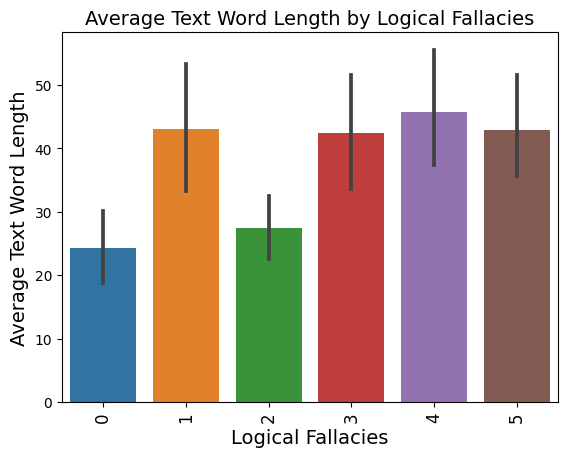

In [27]:
sns.barplot(data=df_error_test, x='true_label', y='text_word_length')
plt.title("Average Text Word Length by Logical Fallacies", fontsize=14)
plt.xlabel("Logical Fallacies", fontsize=14)
plt.ylabel("Average Text Word Length", fontsize=14)

plt.xticks(rotation=90, fontsize=12)
plt.show()

In [28]:
df_error_test.describe()

,dataset,true_label,pred_label,text_char_length,text_word_length
count,211.00,211.00,211.00,211.00,211.00
mean,4.36,2.77,2.75,204.99,37.69
std,2.67,1.78,1.81,142.71,26.36
min,1.00,0.00,0.00,12.00,2.00
25%,3.00,1.00,1.00,98.00,18.00
50%,3.00,3.00,3.00,182.00,33.00
75%,8.00,4.00,4.00,274.00,52.00
max,9.00,5.00,5.00,809.00,148.00


In [29]:
df_error_test.groupby(['true_label', 'pred_label']).count()

text  dataset  text_char_length  text_word_length
true_label pred_label                                                   
0          1              6        6                 6                 6
           2             15       15                15                15
           3              3        3                 3                 3
           4              9        9                 9                 9
           5              3        3                 3                 3
1          0              4        4                 4                 4
           2              4        4                 4                 4
           3              1        1                 1                 1
           4              7        7                 7                 7
           5              6        6                 6                 6
2          0             11       11                11                11
           1              8        8                 8                 8
           3              3        3                 3                 3
           4              9        9                 9                 9
           5              5        5                 5                 5
3          0              4        4                 4                 4
           1              4        4                 4                 4
           2              2        2                 2                 2
           4              2        2                 2                 2
           5             11       11                11                11
4          0              7        7                 7                 7
           1              9        9                 9                 9
           2              5        5                 5                 5
           3              6        6                 6                 6
           5             22       22                22                22
5          0              7        7                 7                 7
           1              8        8                 8                 8
           2              3        3                 3                 3
           3              3        3                 3                 3
           4             24       24                24                24

In [30]:
def get_df_for_error(output, encoded_df, true_label, error_label,):
    y_pred = np.argmax(output.predictions, axis=1)
    y_true = output.label_ids
    encoded_df = encoded_df.reset_index()

    text = []
    dataset = []

    label = []
    error = []

    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if (true == true_label) and (pred == error_label):
            text.append(encoded_df['text'][i])
            dataset.append(encoded_df['dataset'][i])
            label.append(true)
            error.append(pred)

    df = pd.DataFrame({'text': text, 'dataset': dataset,'label': label, 'error': error})
    df['text_char_length'] = df['text'].map(lambda x : len(x))
    df['text_word_length'] = df['text'].str.split().str.len()
    return df



    0: "ad_hominem",
    1: "appeal_to_authority",
    2: "appeal_to_emotion",
    3: "false_dilemma",
    4: "faulty_generalization",
    5: "none"

In [31]:
df_5_4 = get_df_for_error(test_output, X_test, 5, 4)
df_5_4['text_word_length'].mean()

NameError: name 'X_test' is not defined

In [ ]:
df_2_4 = get_df_for_error(test_output, X_test, 2, 4)
df_2_4['text_word_length'].mean()

In [ ]:
df_0_4 = get_df_for_error(test_output, X_test, 0, 4)
df_0_4['text_word_length'].mean()

In [ ]:
df_3_5 = get_df_for_error(test_output, X_test, 3,5)
df_3_5['text_word_length'].mean()

In [ ]:
df_4_5 = get_df_for_error(test_output, X_test, 4,5)
df_4_5['text_word_length'].mean()

In [ ]:
df_small = pd.read_csv("../data/data_small.csv")
df_small['text_char_length'] = df_small['text'].map(lambda x : len(x))
df_small['text_word_length'] = df_small['text'].str.split().str.len()
array = df_small.groupby('logical_fallacies').mean('text_word_length')
array['text_word_length']

In [ ]:
df_false_pred = pd.DataFrame({'whole small df': array['text_word_length']}, index=['ad_hominem', 'appeal_to_authority', 'appeal_to_emotion', 'false_dilemma', 'faulty_generalization', 'none'])

In [ ]:
df_false_pred['5_4'] = [0, 0, 0, 0, 0, df_5_4['text_word_length'].mean()]
df_false_pred['2_4'] = [0, 0, df_2_4['text_word_length'].mean(), 0, 0, 0]
df_false_pred['0_4'] = [ df_0_4['text_word_length'].mean(), 0, 0, 0, 0, 0,]
df_false_pred['3_5'] = [0, 0, 0, df_3_5['text_word_length'].mean(),0, 0]
df_false_pred['4_5'] = [0, 0, 0, 0, df_4_5['text_word_length'].mean(), 0]


In [ ]:
df_false_pred